# Modelo Probabilístico de Previsão de Infarto Cardíaco via Processos Gaussianos

## Importando bibliotecas

In [36]:
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import plotly.offline as pyo
import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot_mpl
init_notebook_mode(connected=True)
cf.go_offline()
from IPython.display import display, HTML
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import KFold, GridSearchCV
import matplotlib.pyplot as plt
import numpy as np
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.gaussian_process.kernels import RBF, Matern, RationalQuadratic, DotProduct, PairwiseKernel
import matplotlib.gridspec as gridspec
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore")

## Visualizando dados

In [37]:
df = pd.read_csv('./dataset_ic2023.csv', sep = ";")
df.head()

,Colesterol Total,Idade,Glicemia,Desfecho,Unnamed: 4
0,254,38,93,1,NaN
1,222,79,89,-1,NaN
2,236,64,102,-1,NaN
3,241,50,123,-1,NaN
4,167,34,82,-1,NaN


In [38]:
df.shape

(799, 5)

In [39]:
df.isna().sum()

Colesterol Total      0
Idade                 0
Glicemia              0
Desfecho              0
Unnamed: 4          799
dtype: int64

In [40]:
df = df.drop(df.columns[4], axis=1)
df.head()

,Colesterol Total,Idade,Glicemia,Desfecho
0,254,38,93,1
1,222,79,89,-1
2,236,64,102,-1
3,241,50,123,-1
4,167,34,82,-1


In [41]:
df.dtypes

Colesterol Total    int64
Idade               int64
Glicemia            int64
Desfecho            int64
dtype: object

## Range dos dados

In [42]:
data_ranges = []
for column in df.columns:
    min_value = df[column].min()
    max_value = df[column].max()
    data_ranges.append([column, f"{min_value} - {max_value}"])

ranges_df = pd.DataFrame(data_ranges, columns=['column', 'range'])
print(ranges_df)

             column      range
0  Colesterol Total  150 - 279
1             Idade    10 - 86
2          Glicemia   64 - 169
3          Desfecho     -1 - 1


## Boxplot das covaráveis

In [43]:
# lista de boxplots cada coluna
traces = []
for col in df.columns[:3]:  # Use as primeiras 3 colunas como valores de x
    trace = go.Box(y=df[col], name=col)
    traces.append(trace)

# Figura
fig = go.Figure(data=traces)

fig.update_layout(
    yaxis=dict(title='Distribuição dos dados', title_font=dict(size=16)),  # Defina o tamanho da fonte do rótulo do eixo y
    xaxis=dict(tickfont=dict(size=16)),  # Defina o tamanho da fonte dos rótulos do eixo x
    legend=dict(orientation="h", x=0.08, y=1.1, font=dict(size=16)),  # Defina o tamanho da fonte da legenda
    width=600,  # Ajuste a largura do gráfico
    height=600  # Torne o gráfico quadrado
)

fig.show()

## Matriz de correlação

In [44]:
# Calcular matriz de correlação
correlation_matrix = df.corr()

# paleta de cores personalizada "coolwarm" usando valores RGB
coolwarm_colors = [
    [0, 'rgb(58, 76, 192)'],
    [0.1, 'rgb(68, 90, 204)'],
    [0.2, 'rgb(77, 104, 215)'],
    [0.3, 'rgb(86, 117, 225)'],
    [0.4, 'rgb(95, 130, 234)'],
    [0.5, 'rgb(139, 151, 255)'],
    [0.6, 'rgb(198, 184, 241)'],
    [0.7, 'rgb(214, 204, 241)'],
    [0.8, 'rgb(229, 224, 242)'],
    [0.9, 'rgb(245, 245, 245)'],
    [1, 'rgb(250, 230, 230)']
]

# mapa de calor da matriz de correlação usando go.Figure
fig = go.Figure(data=go.Heatmap(
    z=correlation_matrix.values,
    x=correlation_matrix.columns,
    y=correlation_matrix.index,
    colorscale=coolwarm_colors,
    zmin=-1,  # Valor mínimo de correlação
    zmax=1,   # Valor máximo de correlação
    colorbar=dict(title='Correlação'),

))

# anotações de valores de correlação
for i in range(len(correlation_matrix)):
    for j in range(len(correlation_matrix)):
        fig.add_annotation(
            text=str(correlation_matrix.values[i][j].round(2)),
            x=correlation_matrix.columns[j],
            y=correlation_matrix.index[i],
            showarrow=False,
            font=dict(size=16)
        )

# Personalização do layout
fig.update_xaxes(side="top", tickfont=dict(size=14))  # Ajuste o tamanho da fonte do rótulo do eixo x
fig.update_yaxes(tickfont=dict(size=14))  # Ajuste o tamanho da fonte do rótulo do eixo y
fig.update_layout(
    width=600,
    height=600
)

fig.show()


## Tabela desfecho

In [45]:
desfecho_counts = df['Desfecho'].value_counts().reset_index()

desfecho_counts.columns = ['Desfecho', 'Contagem']
desfecho_counts['Percentual'] = (desfecho_counts['Contagem']/df.shape[0]).apply(lambda x: f'{x:.2%}')
desfecho_counts

,Desfecho,Contagem,Percentual
0,-1,535,66.96%
1,1,264,33.04%


## Separação de dados em treino e teste

In [46]:
# Separar as características (X) e a variável de destino (y)
X = df.drop(columns=['Desfecho'])  # Features (age, total cholesterol, glucose)
y = df['Desfecho']  # Labels (outcome)

# Dividir os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

## Treinamento

In [47]:
def train_model(X, y):

    # Inicializar padronizador
    scaler = StandardScaler()

    # Padronizar covariáveis ajustadas aos dados de treino
    X = scaler.fit_transform(X)
    y = y

    # Lista de funções de covariância
    kernels = [
        (1**2)*RBF(), (1**2)*Matern(), (1**2)*RationalQuadratic()
    ]

    # Dicionário para realização de GridSearch
    param_grid = {
        'kernel': kernels,
    }

    # Inicializar GaussianProcessClassifier
    model = GaussianProcessClassifier()

    # Inicializar validação cruzada
    cv = KFold(n_splits=5, shuffle=True, random_state=0)

    # Initializar GridSearch
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv, scoring='accuracy')

    # Ajustar GridSearch aos dados
    grid_search.fit(X, y)

    cv_results = pd.DataFrame(grid_search.cv_results_)

    # Selecionar melhor modelo
    melhor_modelo = grid_search.best_estimator_

    # Retreinar usando todos os dados de treino
    melhor_modelo.fit(X,y)

    return melhor_modelo, cv_results, scaler

In [48]:
melhor_modelo, cv_results, scaler = train_model(X_train, y_train)

## Função de covariância otimizada

In [49]:
melhor_modelo.kernel_

2.25**2 * Matern(length_scale=4.47, nu=1.5)

## Resultados por split da validação cruzada

In [50]:
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,2.484973,0.510956,0.001402,0.001717,1**2 * RBF(length_scale=1),{'kernel': 1**2 * RBF(length_scale=1)},0.820312,0.718750,0.750000,0.757812,0.724409,0.754257,0.036182,2
1,2.629792,0.206779,0.006057,0.003611,"1**2 * Matern(length_scale=1, nu=1.5)","{'kernel': 1**2 * Matern(length_scale=1, nu=1.5)}",0.820312,0.726562,0.742188,0.765625,0.732283,0.757394,0.034173,1
2,7.400284,0.786450,0.006075,0.003221,"1**2 * RationalQuadratic(alpha=1, length_scale=1)","{'kernel': 1**2 * RationalQuadratic(alpha=1, l...",0.820312,0.718750,0.750000,0.757812,0.724409,0.754257,0.036182,2


In [51]:
cv_results['mean_test_score'] = cv_results['mean_test_score'].round(3)
cv_results['std_test_score'] = cv_results['std_test_score'].round(3)

cv_results.iloc[:,5:13]

,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score
0,{'kernel': 1**2 * RBF(length_scale=1)},0.820312,0.718750,0.750000,0.757812,0.724409,0.754,0.036
1,"{'kernel': 1**2 * Matern(length_scale=1, nu=1.5)}",0.820312,0.726562,0.742188,0.765625,0.732283,0.757,0.034
2,"{'kernel': 1**2 * RationalQuadratic(alpha=1, l...",0.820312,0.718750,0.750000,0.757812,0.724409,0.754,0.036


## Teste

In [52]:
def test_model(model, X, y, scaler=scaler, prob = 0.5):
    # Apply the same transformation to the test data
    X_test = scaler.transform(X)

    # Make predictions on the test data
    y_pred = model.predict_proba(X_test)[:,1]
    y_pred_texto = np.where(y_pred > prob, 'infartou', 'não infartou')
    # Generate a classification report
    y_texto = np.where(y == 1, 'infartou', 'não infartou')
    class_report = classification_report(y_texto, y_pred_texto)

    # Print the classification report
    print("Classification Report:")
    print(class_report)


In [53]:
test_model(melhor_modelo, X_test, y_test) # scaler = scaler, prob = 0.5

Classification Report:
              precision    recall  f1-score   support

    infartou       0.77      0.47      0.58        58
não infartou       0.75      0.92      0.83       102

    accuracy                           0.76       160
   macro avg       0.76      0.69      0.70       160
weighted avg       0.76      0.76      0.74       160



In [54]:
test_model(melhor_modelo, X_test, y_test, prob = 0.3) # scaler = scaler

Classification Report:
              precision    recall  f1-score   support

    infartou       0.65      0.76      0.70        58
não infartou       0.85      0.76      0.80       102

    accuracy                           0.76       160
   macro avg       0.75      0.76      0.75       160
weighted avg       0.78      0.76      0.77       160



In [55]:
test_model(melhor_modelo, X_test, y_test, prob = 0.7) # scaler = scaler

Classification Report:
              precision    recall  f1-score   support

    infartou       0.89      0.28      0.42        58
não infartou       0.70      0.98      0.82       102

    accuracy                           0.73       160
   macro avg       0.80      0.63      0.62       160
weighted avg       0.77      0.72      0.68       160



## Curvas de probabilidade preditiva a posteriori

In [56]:
# Create a meshgrid for visualization
x_min, x_max = X.iloc[:, 0].min() - 1, X.iloc[:, 0].max() + 1
y_min, y_max = X.iloc[:, 1].min() - 1, X.iloc[:, 1].max() + 1
z_min, z_max = X.iloc[:, 2].min() - 1, X.iloc[:, 2].max() + 1

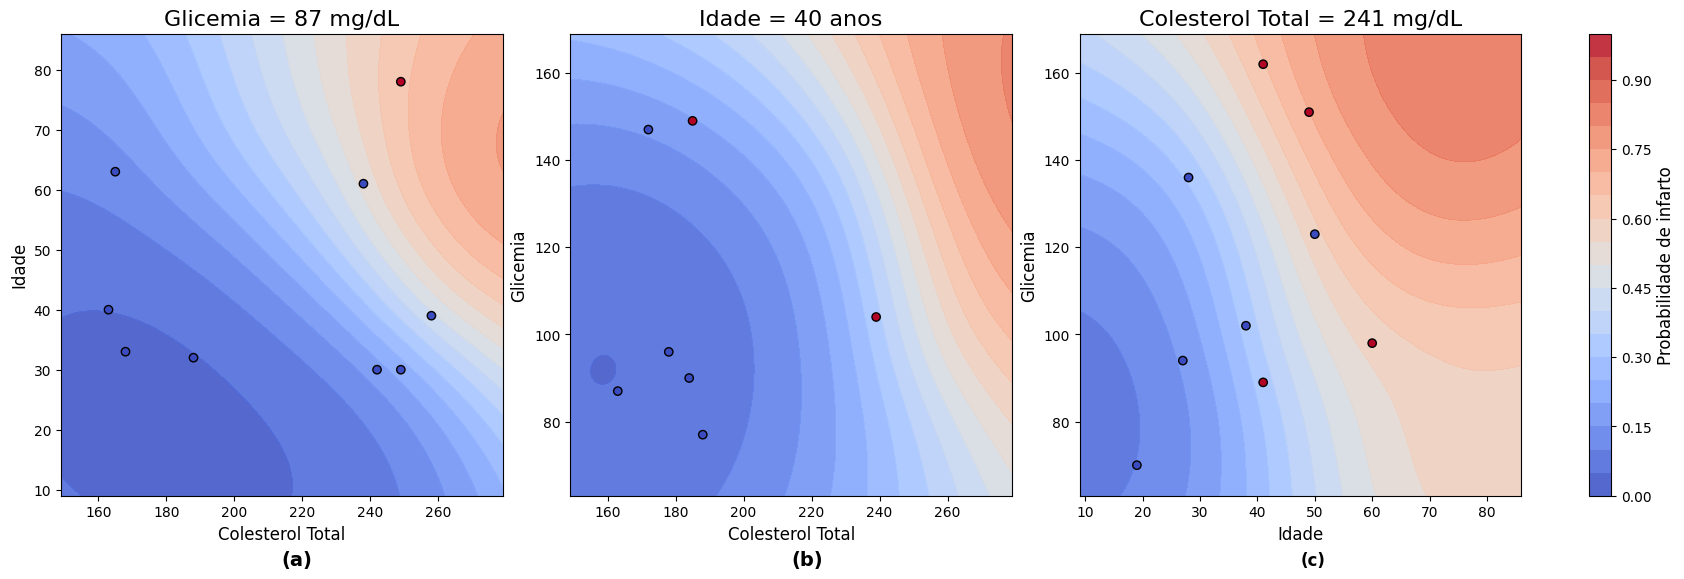

In [64]:
# Create a figure and a gridspec layout
fig = plt.figure(figsize=(20, 6))
gs = gridspec.GridSpec(1, 4, width_ratios=[1, 1, 1, 0.05]) 

# Create subplots within the gridspec layout
axs = [plt.subplot(gs[i]) for i in range(3)]

# Create colorbar subplot
cax = plt.subplot(gs[3])

for i in range(3):
    if i == 0:
        xx, yy, zz = np.meshgrid(np.arange(x_min, x_max, 1), np.arange(y_min, y_max, 1), X_test.iloc[:,2].mode())
        grid_points = np.c_[xx.ravel(), yy.ravel(), zz.ravel()]
    elif i == 1:
        xx, yy, zz = np.meshgrid(np.arange(x_min, x_max, 1), np.arange(z_min, z_max, 1), X_test.iloc[:,1].mode())
        grid_points = np.c_[xx.ravel(), zz.ravel(), yy.ravel()]
    else:
        xx, yy, zz = np.meshgrid(np.arange(y_min, y_max, 1), np.arange(z_min, z_max, 1), X_test.iloc[:,0].mode())
        grid_points = np.c_[zz.ravel(), xx.ravel(), yy.ravel()]

    # Get predicted probabilities
    probs = melhor_modelo.predict_proba(scaler.transform(grid_points))[:, 1] #índice 0 desfecho = -1, índice 1 desfecho = 1
    probs = probs.reshape(xx.shape)

    if i == 0:
        contour = axs[0].contourf(xx[:, :, 0], yy[:, :, 0], probs[:, :, 0], levels=np.linspace(0, 1, 21), cmap=plt.cm.coolwarm, alpha=0.9)
        x_plot = X_test.loc[X_test.iloc[:, 2] == X_test.iloc[:, 2].mode().iloc[0]]
        axs[i].scatter(x_plot.iloc[:, 0], x_plot.iloc[:, 1], c=y_test[x_plot.index], cmap=plt.cm.coolwarm, edgecolor='k')
        axs[i].set_xlabel(x_plot.columns[0], fontsize=12)
        axs[i].set_ylabel(x_plot.columns[1], fontsize=12)
        axs[i].set_title(f"{x_plot.columns[2]} = {X_test.iloc[:, 2].mode().iloc[0]} mg/dL", fontsize=16)
        axs[i].text(0.5, -0.15, "(a)", transform=axs[i].transAxes, fontsize=14, weight='bold')

    if i == 1:
        contour = axs[1].contourf(xx[:, :, 0], yy[:, :, 0], probs[:, :, 0], levels=np.linspace(0, 1, 21), cmap=plt.cm.coolwarm, alpha=0.9)
        x_plot = X_test.loc[X_test.iloc[:, 1] == X_test.iloc[:, 1].mode().iloc[0]]
        axs[i].scatter(x_plot.iloc[:, 0], x_plot.iloc[:, 2], c=y_test[x_plot.index], cmap=plt.cm.coolwarm, edgecolor='k')
        axs[i].set_xlabel(x_plot.columns[0], fontsize=12)
        axs[i].set_ylabel(x_plot.columns[2], fontsize=12)
        axs[i].set_title(f"{X_test.columns[1]} = {X_test.iloc[:, 1].mode().iloc[0]} anos", fontsize=16)
        axs[i].text(0.5, -0.15, "(b)", transform=axs[i].transAxes, fontsize=14, weight='bold')

    elif i == 2:
        contour = axs[2].contourf(xx[:, :, 0], yy[:, :, 0], probs[:, :, 0], levels=np.linspace(0, 1, 21), cmap=plt.cm.coolwarm, alpha=0.9)
        x_plot = X_test.loc[X_test.iloc[:, 0] == X_test.iloc[:, 0].mode().iloc[0]]
        axs[i].scatter(x_plot.iloc[:, 1], x_plot.iloc[:, 2], c=y_test[x_plot.index], cmap=plt.cm.coolwarm, edgecolor='k')
        axs[i].set_xlabel(x_plot.columns[1], fontsize=12)
        axs[i].set_ylabel(x_plot.columns[2], fontsize=12)
        axs[i].set_title(f"{X_test.columns[0]} = {X_test.iloc[:, 0].mode().iloc[0]} mg/dL", fontsize=16)
        axs[i].text(0.5, -0.15, "(c)", transform=axs[i].transAxes, fontsize=12, weight='bold')

cbar = fig.colorbar(contour, cax=cax, label='Probabilidade de infarto')
cbar.set_label('Probabilidade de infarto', fontsize=12)

# Display the subplot
plt.show()

## Checando resultados da visualização

In [79]:
plot_1 = X_test.loc[X_test['Glicemia'] == 87]
plot_2 = X_test.loc[X_test['Idade'] == 40]
plot_3 = X_test.loc[X_test['Colesterol Total'] == 241]

### Caso 1: Glicemia = 87

In [75]:
plot_1 = plot_1.merge(y_test.loc[X_test['Glicemia'] == 87], left_index=True, right_index=True, how='left')
plot_1['prob'] = melhor_modelo.predict_proba(np.array(scaler.transform(plot_1.iloc[:, :3])))[:, 1]
plot_1

,Colesterol Total,Idade,Glicemia,Desfecho,prob
370,258,39,87,-1,0.437375
81,165,63,87,-1,0.130349
531,188,32,87,-1,0.048553
262,163,40,87,-1,0.050716
555,168,33,87,-1,0.041017
339,238,61,87,-1,0.515020
414,249,30,87,-1,0.225104
223,242,30,87,-1,0.180605
358,249,78,87,1,0.636073


### Caso 2: Idade = 40

In [76]:
plot_2 = plot_2.merge(y_test.loc[X_test['Idade'] == 40], left_index=True, right_index=True, how='left')
plot_2['prob'] = melhor_modelo.predict_proba(np.array(scaler.transform(plot_2.iloc[:, :3])))[:, 1]
plot_2

,Colesterol Total,Idade,Glicemia,Desfecho,prob
262,163,40,87,-1,0.050716
241,239,40,104,1,0.333766
50,188,40,77,-1,0.076212
708,178,40,96,-1,0.057624
57,184,40,90,-1,0.063768
780,185,40,149,1,0.196237
696,172,40,147,-1,0.158832


### Caso 3: Colesterol total = 241

In [80]:
plot_3 = plot_3.merge(y_test.loc[X_test['Colesterol Total'] == 241], left_index=True, right_index=True, how='left')
plot_3['prob'] = melhor_modelo.predict_proba(np.array(scaler.transform(plot_3.iloc[:, :3])))[:, 1]
plot_3

,Colesterol Total,Idade,Glicemia,Desfecho,prob
539,241,49,151,1,0.699278
725,241,28,136,-1,0.309610
194,241,60,98,1,0.569032
101,241,41,89,1,0.325468
488,241,38,102,-1,0.318098
59,241,19,70,-1,0.101144
3,241,50,123,-1,0.582956
375,241,27,94,-1,0.158560
467,241,41,162,1,0.645333


## Matriz de confusão

In [62]:
def cm_analysis(y_true_list, y_pred_list, labels, titulos = ['Matriz de confusão'], ymap=None, figsize=(10, 10)):
    """
    Generate matrix plot of confusion matrix with pretty annotations.
    The plot image is saved to disk.
    args: 
      y_true_list:    List of true labels, each with shape (nsamples,)
      y_pred_list:    List of predictions, each with shape (nsamples,)
      labels:    string array, name the order of class labels in the confusion matrix.
                 use `clf.classes_` if using scikit-learn models.
                 with shape (nclass,).
      ymap:      dict: any -> string, length == nclass.
                 if not None, map the labels & ys to more understandable strings.
                 Caution: original y_true, y_pred, and labels must align.
      figsize:   the size of the figure plotted.
    """
    if isinstance(y_true_list, list):
        num_plots = len(y_true_list)
    else:
        num_plots = 1
        y_true_list = [y_true_list]
        y_pred_list = [y_pred_list]

    if ymap is not None:
        # Change category codes or labels to new labels 
        y_pred_list = [[ymap[yi] for yi in y_pred] for y_pred in y_pred_list]
        y_true_list = [[ymap[yi] for yi in y_true] for y_true in y_true_list]
        labels = [ymap[yi] for yi in labels]

    # Create subplots based on the number of plots
    if num_plots == 1:
        fig, ax = plt.subplots(figsize=figsize)
        axes = [ax]
    else:
        fig, axes = plt.subplots(1, num_plots, figsize=(figsize[0] * num_plots, figsize[1]))

    for i in range(num_plots):
        # Calculate a confusion matrix with the new labels
        cm = confusion_matrix(y_true_list[i], y_pred_list[i], labels=labels)
        # Calculate row sums (for calculating % & plot annotations)
        cm_sum = np.sum(cm, axis=1, keepdims=True)
        # Calculate proportions
        cm_perc = cm / cm_sum.astype(float) * 100
        # Empty array for holding annotations for each cell in the heatmap
        annot = np.empty_like(cm).astype(str)
        # Get the dimensions
        nrows, ncols = cm.shape
        # Cycle over cells and create annotations for each cell
        for j in range(nrows):
            for k in range(ncols):
                # Get the count for the cell
                c = cm[j, k]
                # Get the percentage for the cell
                p = cm_perc[j, k]
                if j == k:
                    s = cm_sum[j]
                    # Convert the proportion, count, and row sum to a string with pretty formatting
                    annot[j, k] = '%d\n%.1f%%' % (c, p)
                elif c == 0:
                    annot[j, k] = '%d' % (c)
                else:
                    annot[j, k] = '%d\n%.1f%%' % (c, p)
        # Convert the array to a dataframe
        cm = pd.DataFrame(cm, index=labels, columns=labels)
        cm.index.name = 'Verdadeiro'
        cm.columns.name = 'Predição'
        # Plot the data using the Pandas dataframe
        heatmap = sns.heatmap(cm, annot=annot, fmt='', ax=axes[i], cmap='rocket_r', annot_kws={"size": 30})
        heatmap.set_xticklabels(heatmap.get_xticklabels(), fontsize=12)
        heatmap.set_yticklabels(heatmap.get_yticklabels(), fontsize=12)
        axes[i].set_xlabel('Predição', fontsize=15)
        axes[i].set_ylabel('Verdadeiro', fontsize=15)
        
        axes[i].set_title(titulos[i])
        
        if i != num_plots - 1:
            axes[i].collections[0].colorbar.remove()

    axes[num_plots - 1].collections[0].colorbar.ax.tick_params(labelsize=12)

    plt.tight_layout()
    plt.show()

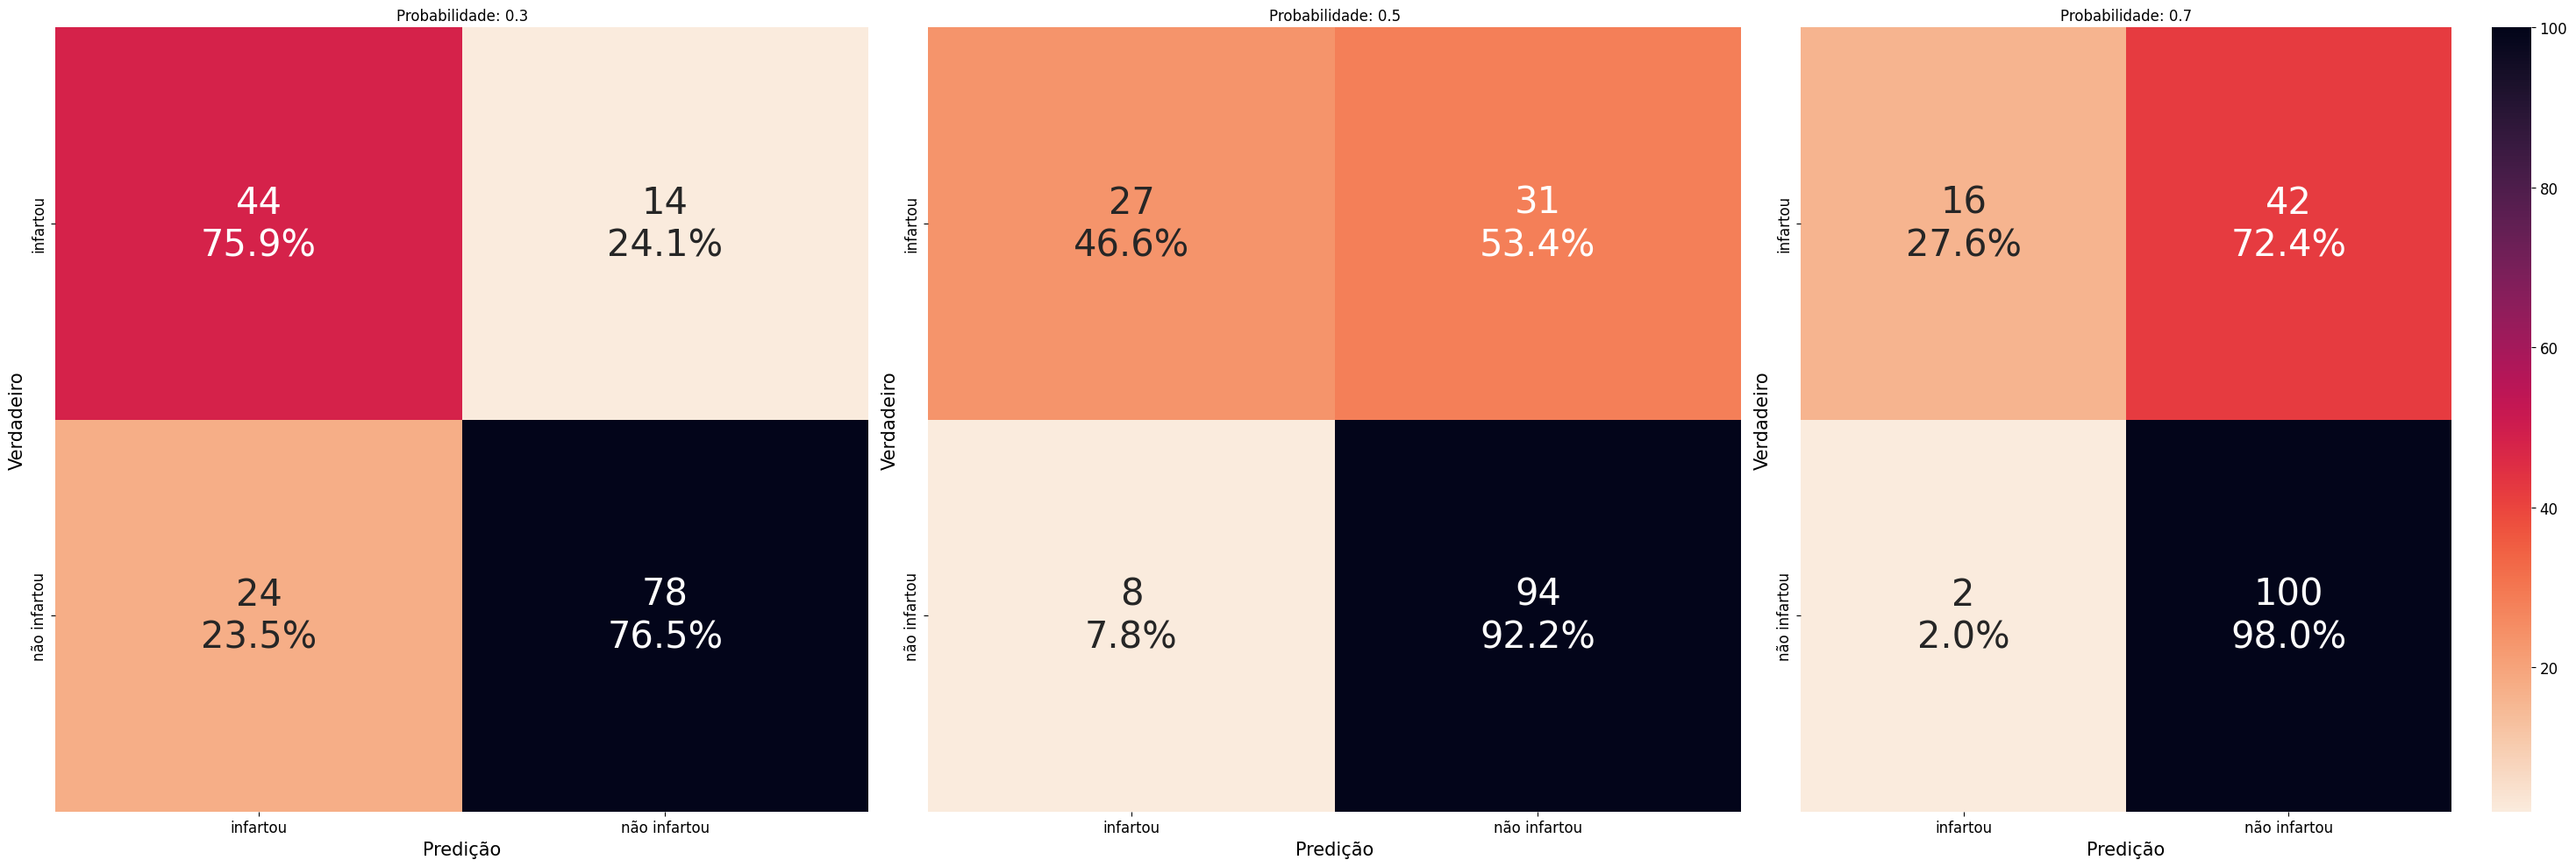

In [63]:
def confusion_matrix_plot(model, X, y, scaler = scaler, prob = [0.3,0.5,0.7]):
    
    # Apply the same transformation to the test data
    X_test = scaler.transform(X)

    # Generate a classification report
    y_texto = np.where(y == 1, 'infartou', 'não infartou')

    y_pred_list = []
    y_true_list = []
    titulos_list = []

    for prob in prob:
    # Make predictions on the test data
        y_pred = model.predict_proba(X_test)[:,1]
        y_pred_texto = np.where(y_pred > prob, 'infartou', 'não infartou')

        y_true_list.append(y_texto)
        y_pred_list.append(y_pred_texto)
        titulos_list.append(f'Probabilidade: {prob}')
    
    cm_analysis(y_true_list,y_pred_list, labels = ['infartou', 'não infartou'], titulos=titulos_list)
    
confusion_matrix_plot(melhor_modelo, X_test, y_test, scaler, prob = [0.3,0.5,0.7])
